이전 두 시즌의 통계적 수치를 입력 변수로 사용하여 NBA 선수들의 연봉을 예측하는 인공지능 모델을 구축하는 프로젝트

## Import packages and data

해당 프로젝트에서는 2020/21 시즌 및 2021/22 시즌 NBA 선수별 통계 기록과 2022/23 시즌 NBA 선수 연봉을 데이터로 활용한다.

In [1]:
# Data Manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import missingno as msno

In [2]:
# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import model_selection, metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [4]:
# Other packages
from scipy.stats import norm
from scipy import stats

In [5]:
# Import data
df_salary = pd.read_csv('./file/NBA_Player_Salary.csv')
df_stats2021 = pd.read_csv('./file/NBA_Player_Stats(2021).csv')
df_stats2122 = pd.read_csv('./file/NBA_Player_Stats(2122).csv')
df_list = [df_stats2021, df_stats2122, df_salary]

## 1. Data Cleaning

데이터셋으로 지정된 파일 각각의 처음 다섯 행을 살펴본다.

In [6]:
# Salary
df_salary.head()

,Rk,Player,Tm,2022-23,2023-24,2024-25,2025-26,2026-27,2027-28,Signed Using,Guaranteed
0,1,Stephen Curry,GSW,48070014.0,51915615.0,55761216.0,59606817.0,NaN,NaN,Bird,"$215,353,662"
1,2,Russell Westbrook,LAL,47063478.0,NaN,NaN,NaN,NaN,NaN,Bird Rights,"$47,063,478"
2,3,LeBron James,LAL,44474988.0,NaN,NaN,NaN,NaN,NaN,Bird,"$44,474,988"
3,4,Kevin Durant,BRK,44119845.0,47649433.0,51179021.0,54708609.0,NaN,NaN,Bird,"$197,656,908"
4,5,Bradley Beal,WAS,43279250.0,46741590.0,50203930.0,53666270.0,57128610.0,NaN,Bird,"$193,891,040"


In [7]:
# Season Stats 20/21
df_stats2021.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Precious Achiuwa,PF,21,MIA,61,4,737,124,228,...,13.5,19.5,0.3,1.0,1.3,0.085,-3.6,-0.5,-4.1,-0.4
1,2,Jaylen Adams,PG,24,MIL,7,0,18,1,8,...,0.0,18.6,-0.1,0.0,-0.1,-0.252,-15.1,-4.6,-19.8,-0.1
2,3,Steven Adams,C,27,NOP,58,58,1605,189,308,...,17.5,11.7,2.3,1.7,4.0,0.119,-0.4,0.1,-0.3,0.7
3,4,Bam Adebayo,C,23,MIA,64,64,2143,456,800,...,15.0,23.7,5.6,3.2,8.8,0.197,2.9,2.0,4.9,3.7
4,5,LaMarcus Aldridge,C,35,TOT,26,23,674,140,296,...,7.9,22.2,0.5,0.6,1.1,0.080,-0.2,-0.2,-0.3,0.3


In [8]:
# Season Stats 21/22
df_stats2122.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Precious Achiuwa,C,22,TOR,73,28,1725,265,603,...,11.3,18.5,0.4,2.1,2.5,0.070,-2.0,-0.6,-2.6,-0.2
1,2,Steven Adams,C,28,MEM,76,75,1999,210,384,...,19.6,12.0,3.8,3.0,6.8,0.163,1.0,1.0,2.0,2.0
2,3,Bam Adebayo,C,24,MIA,56,56,1825,406,729,...,14.4,25.0,3.6,3.5,7.2,0.188,1.7,2.1,3.8,2.7
3,4,Santi Aldama,PF,21,MEM,32,0,360,53,132,...,9.9,18.4,-0.1,0.4,0.3,0.044,-4.2,-1.5,-5.7,-0.3
4,5,LaMarcus Aldridge,C,36,BRK,47,12,1050,252,458,...,8.0,22.4,2.1,1.0,3.1,0.141,1.3,-0.6,0.7,0.7


2022/23 시즌 선수들의 연봉을 예측하는 것이 프로젝트의 목표이므로 해당 시즌의 연봉에 관한 열을 가공한다.

In [9]:
# Rename salary column
df_salary = df_salary.rename(columns = {'2022-23': 'Salary 22/23'})

# Transform salary to 1000
df_salary['Salary 22/23'] = df_salary['Salary 22/23']/1000

시즌별 선수 통계 데이터셋에서 동일 플레이어에 대한 중복 행을 삭제한다.
* 프로젝트의 목표인 2022/23 시즌 연봉을 구하는 데 있어서 선수가 한 시즌 동안 어느 팀에서 뛰었는 지는 중요한 요소가 아니다.<br>그러므로 해당 시즌 동안 여러 팀에서 뛴 선수들의 행을 하나로 통합한다.  

In [10]:
# As total stats always is in the top row we can simply use the drop_duplicates function
df_stats2021 = df_stats2021.drop_duplicates(['Player'])
df_stats2122 = df_stats2122.drop_duplicates(['Player'])

### Merge Datasets

각 시즌별 선수 통계 데이터셋의 모든 열에 해당하는 연도를 할당한다.

In [11]:
# Add season year to corresponding columns
columns_renamed = [s + ' 20/21' for s in list(df_stats2021.columns)]
df_stats2021.columns = list(df_stats2021.columns)[:3] + columns_renamed[3:]

columns_renamed = [s + ' 21/22' for s in list(df_stats2122.columns)]
df_stats2122.columns = list(df_stats2122.columns)[:3] + columns_renamed[3:]

# Delete Pos column from 17/18 df; we need it only once
df_stats2021 = df_stats2021.drop('Pos', axis = 1)

In [12]:
# Merge datasets
df_stats = df_stats2021.merge(df_stats2122, how = 'outer',left_on = ['Player'],right_on = ['Player'])
df = df_stats.merge(df_salary, how = 'outer', left_on = ['Player'],right_on = ['Player'])

df.head()

,Rk_x,Player,Age 20/21,Tm 20/21,G 20/21,GS 20/21,MP 20/21,FG 20/21,FGA 20/21,FG% 20/21,...,Rk,Tm,Salary 22/23,2023-24,2024-25,2025-26,2026-27,2027-28,Signed Using,Guaranteed
0,1.0,Precious Achiuwa,21.0,MIA,61.0,4.0,737.0,124.0,228.0,0.544,...,300.0,TOR,2840.160,4379527.0,NaN,NaN,NaN,NaN,1st Round Pick,"$2,840,160"
1,2.0,Jaylen Adams,24.0,MIL,7.0,0.0,18.0,1.0,8.0,0.125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,Steven Adams,27.0,NOP,58.0,58.0,1605.0,189.0,308.0,0.614,...,79.0,MEM,17926.829,NaN,NaN,NaN,NaN,NaN,1st Round Pick,"$17,926,829"
3,4.0,Bam Adebayo,23.0,MIA,64.0,64.0,2143.0,456.0,800.0,0.570,...,39.0,MIA,30351.780,32600060.0,34848340.0,37096620.0,NaN,NaN,Bird,"$134,896,800"
4,5.0,LaMarcus Aldridge,35.0,TOT,26.0,23.0,674.0,140.0,296.0,0.473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


데이터셋의 각각의 열에 해당하는 데이터 타입을 확인한다.

In [13]:
df.dtypes

Rk_x            float64
Player           object
Age 20/21       float64
Tm 20/21         object
G 20/21         float64
                 ...   
2025-26         float64
2026-27         float64
2027-28         float64
Signed Using     object
Guaranteed       object
Length: 108, dtype: object

### Drop unnecessary columns

앞으로의 프로젝트 과정에서 사용되지 않는 일부 열을 제거한다.

In [14]:
# Columns of dataset
df.columns

Index(['Rk_x', 'Player', 'Age 20/21', 'Tm 20/21', 'G 20/21', 'GS 20/21',
       'MP 20/21', 'FG 20/21', 'FGA 20/21', 'FG% 20/21',
       ...
       'Rk', 'Tm', 'Salary 22/23', '2023-24', '2024-25', '2025-26', '2026-27',
       '2027-28', 'Signed Using', 'Guaranteed'],
      dtype='object', length=108)

In [15]:
# Drop unnecessary columns
df = df.drop(['Rk_x', 'Rk_y', 'Rk', 'Tm', '2023-24', '2024-25', '2025-26', '2026-27', '2027-28',
              'Signed Using', 'Guaranteed'], axis = 1)

### Missing values

각 열에 존재하는 결측값을 확인한다.

In [16]:
# Number of missing values for each column
df.isnull().sum()

Player            0
Age 20/21       203
Tm 20/21        203
G 20/21         203
GS 20/21        203
               ... 
OBPM 21/22      139
DBPM 21/22      139
BPM 21/22       139
VORP 21/22      139
Salary 22/23    281
Length: 97, dtype: int64

20/21 시즌과 21/22 시즌에 대하여 Salary나 Stat 정보가 없는 행은 제거한다.

* 선수들 중 일부는 20/21 시즌이나 21/22 시즌에 출전하지 않았으며, 몇몇 선수들은 21/22 시즌에 대한 계약을 맺지 못했다.<br> 이러한 경우는 연봉을 예측하는 데 있어서 도움이 되지 못하기 때문에 결측값으로 판단하여 제거하는 것이 합리적이다.

In [17]:
# Drop rows with NaN
# Create Dataframe without stats for season 20/21
df1 = df.dropna(subset = ['Salary 22/23', 'PTS 21/22', 'eFG% 21/22'])
df1 = df1.reset_index()
columns = list(df1.columns)
for i in columns:
    if '20/21' in i:
        df1 = df1.drop([i], axis = 1)
df1 = df1.reset_index()

# Create Dataframe with stats for season 20/21
df2 = df.dropna(subset = ['Salary 22/23', 'PTS 21/22', 'eFG% 21/22', 'PTS 20/21', 'eFG% 20/21'])
df2 = df2.reset_index()

데이터셋 내에 존재하는 포지션을 확인한다.

In [18]:
# Get unique positions
print(df1.Pos.unique())
print(df2.Pos.unique())

['C' 'SG' 'PF' 'SF' 'PG' 'SG-PG' 'PG-SG' 'SF-SG' 'SG-SF' 'C-PF' 'PF-C']
['C' 'SG' 'PF' 'SF' 'PG' 'SG-PG' 'PG-SG' 'SF-SG' 'SG-SF' 'C-PF' 'PF-C']


5개의 포지션: PG, SG , PF, SF, C으로 간소화하여 분류한다.

In [19]:
# Replace duplicate positions with first position.
df1 = df1.replace({'SG-PG': 'SG', 'PG-SG': 'PG', 'SF-SG': 'SF', 'SG-SF':'SG', 'C-PF': 'C', 'PF-C':'PF'})
df2 = df2.replace({'SG-PG': 'SG', 'PG-SG': 'PG', 'SF-SG': 'SF', 'SG-SF':'SG', 'C-PF': 'C', 'PF-C':'PF'})

In [20]:
df1.head()

,level_0,index,Player,Pos,Age 21/22,Tm 21/22,G 21/22,GS 21/22,MP 21/22,FG 21/22,...,USG% 21/22,OWS 21/22,DWS 21/22,WS 21/22,WS/48 21/22,OBPM 21/22,DBPM 21/22,BPM 21/22,VORP 21/22,Salary 22/23
0,0,0,Precious Achiuwa,C,22.0,TOR,73.0,28.0,1725.0,265.0,...,18.5,0.4,2.1,2.5,0.070,-2.0,-0.6,-2.6,-0.2,2840.160
1,1,2,Steven Adams,C,28.0,MEM,76.0,75.0,1999.0,210.0,...,12.0,3.8,3.0,6.8,0.163,1.0,1.0,2.0,2.0,17926.829
2,2,3,Bam Adebayo,C,24.0,MIA,56.0,56.0,1825.0,406.0,...,25.0,3.6,3.5,7.2,0.188,1.7,2.1,3.8,2.7,30351.780
3,3,6,Nickeil Alexander-Walker,SG,23.0,TOT,65.0,21.0,1466.0,253.0,...,24.1,-1.1,1.1,0.1,0.003,-1.8,-1.1,-2.9,-0.3,5009.633
4,4,7,Grayson Allen,SG,26.0,MIL,66.0,61.0,1805.0,255.0,...,15.2,2.8,1.4,4.2,0.110,0.6,-0.2,0.4,1.1,8500.000


주요 기록들에 대한 absolute growth를 얻기 위해서 데이터 프레임(df2)에 대한 20/21 시즌의 통계를 사용한다.

In [21]:
# Get absolute growth
# List of stats of which we want the growth
list_growth = ['eFG%','TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

# Add absolute growth columns
for i in list_growth:
    df2[i + ' +-'] = df2[i + ' 21/22'] - df2[i + ' 20/21']
    
# Drop 17/18 columns
columns = list(df2.columns)
for i in columns:
    if '20/21' in i:
        df2 = df2.drop([i], axis = 1)

In [22]:
print(df1.shape)
print(df2.shape)

(409, 52)
(340, 59)


20/21 시즌과 21/22 시즌에 대한 선수별 통계 기록과 22/23 시즌의 연봉 정보를 가지는 행은 총 340개가 존재한다.<br>
21/22 시즌의 선수별 통계 기록과 22/23 시즌의 연봉 정보를 가지고 있는 행은 409개로, 69개의 추가 행이 있다. 

## 2. Exploring our dataset

### Target variable인 연봉 분석 (1000 단위)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Stephen Curry'),
  Text(1, 0, 'Russell Westbrook'),
  Text(2, 0, 'LeBron James'),
  Text(3, 0, 'Kevin Durant'),
  Text(4, 0, 'Bradley Beal')])

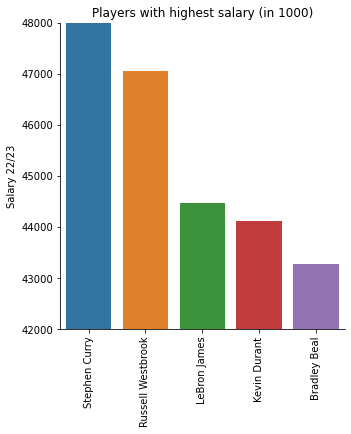

In [23]:
# Setup dataframe
df_sal = df1[['Player', 'Salary 22/23']]
df_sal.sort_values(by = 'Salary 22/23', ascending = False, inplace = True)

# Create barchart
sns.catplot(x = 'Player', y = 'Salary 22/23', kind = 'bar', data = df_sal.head()).set(xlabel = None)
plt.title('Players with highest salary (in 1000)')
plt.ylim([42000, 48000])
plt.xticks(rotation = 90)

연봉 관련 주요 통계적 요소에 대한 정보 요약

In [24]:
# Statistics summary
df1['Salary 22/23'].describe()

count      409.000000
mean      9993.430090
std      10628.437409
min         50.000000
25%       2000.000000
50%       5739.840000
75%      13906.976000
max      48070.014000
Name: Salary 22/23, dtype: float64

연봉 분포(salary distribution)에 대한 히스토그램 모양 확인

C:\Users\borus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Salary 22/23', ylabel='Density'>

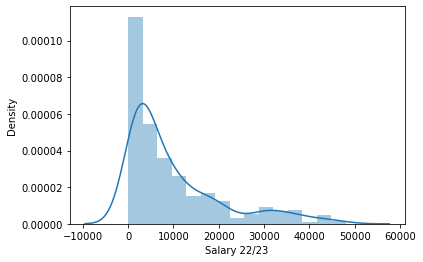

In [25]:
# Histogram
sns.distplot(df1['Salary 22/23'])

히스토그램을 통해 다음을 확인할 수 있다.

1. 연봉이 분산되어 있음을 나타내는 큰 표준 편차
2. 선수들의 연봉이 정규 분포(normal distribution)를 따르지 않음
3. 우편향 분포 (right-skewed distribution)

### Analysis of most important player stats

NBA 선수들의 주요 기록(경기당 득점, 어시스트, 스틸, 리바운드)에 대해 살펴본다.

우선 각 지표의 리더를 확인한다.

[Text(0, 0.5, '')]

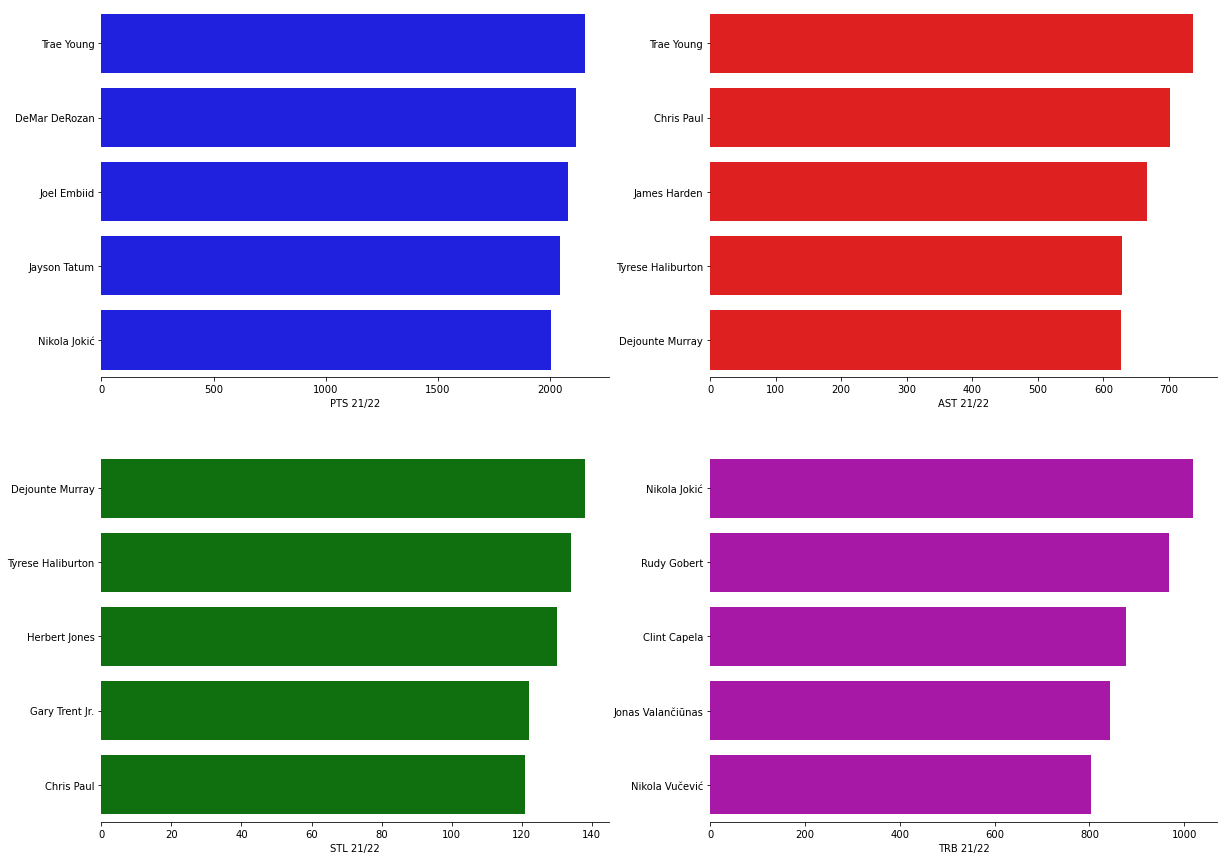

In [26]:
# Setup dataframes
df_pts = df1[['Player', 'PTS 21/22']]
df_pts.sort_values(by = 'PTS 21/22', ascending = False, inplace = True)
df_ast = df1[['Player', 'AST 21/22']]
df_ast.sort_values(by = 'AST 21/22', ascending = False, inplace = True)
df_stl = df1[['Player', 'STL 21/22']]
df_stl.sort_values(by = 'STL 21/22', ascending = False, inplace = True)
df_trb = df1[['Player', 'TRB 21/22']]
df_trb.sort_values(by = 'TRB 21/22', ascending = False, inplace = True)

# Set up figure
f, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.despine(left=True)

# Create barcharts
sns.barplot(x = 'PTS 21/22', y = 'Player', data = df_pts.head(), color = "b", ax = axes[0, 0]).set(ylabel = None)
sns.barplot(x = 'AST 21/22', y = 'Player', data = df_ast.head(), color = "r", ax = axes[0, 1]).set(ylabel = None)
sns.barplot(x = 'STL 21/22', y = 'Player', data = df_stl.head(), color = "g", ax = axes[1, 0]).set(ylabel = None)
sns.barplot(x = 'TRB 21/22', y = 'Player', data = df_trb.head(), color = "m", ax = axes[1, 1]).set(ylabel = None)

히스토그램을 이용하여 각 지표의 분산을 확인한다. 

C:\Users\borus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\borus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\borus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:xlabel='TRB 21/22', ylabel='Density'>

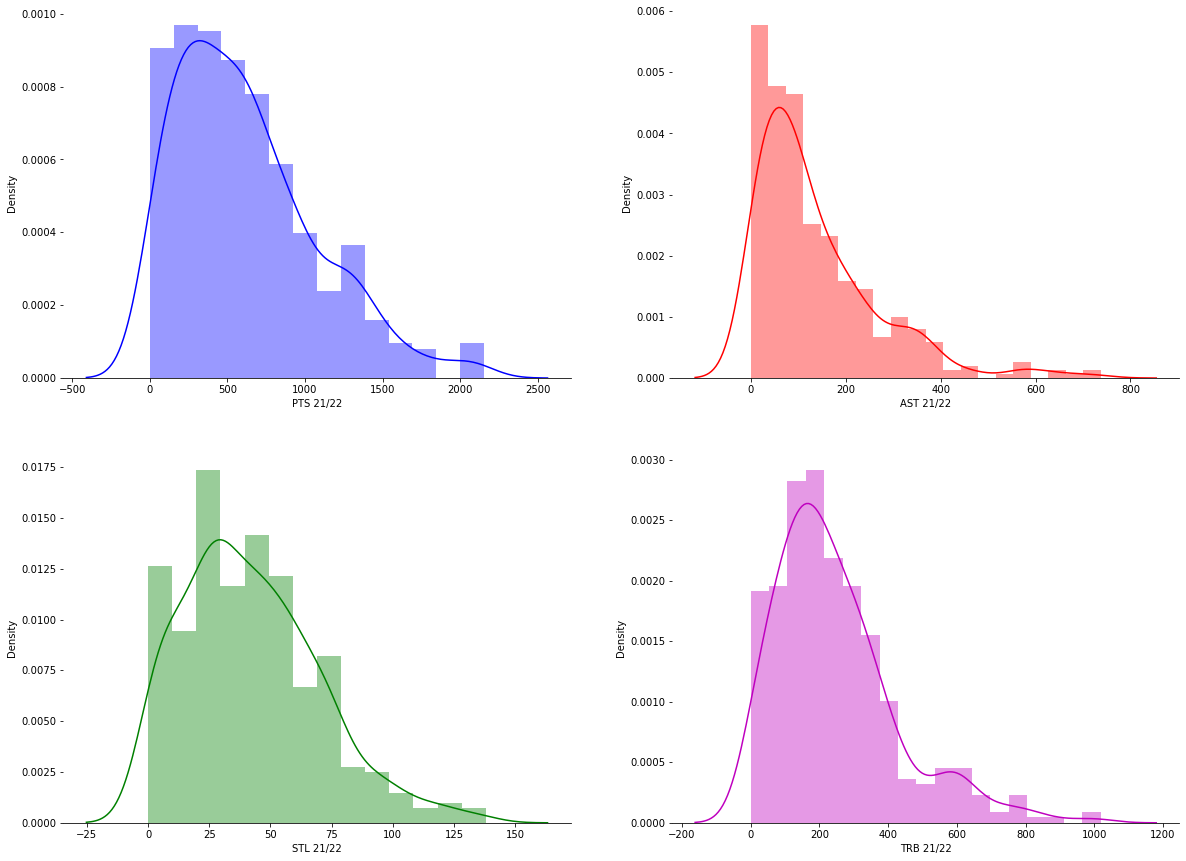

In [27]:
# Set up figure
f, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.despine(left=True)

# Histograms
sns.distplot(df1['PTS 21/22'], color = "b", ax = axes[0, 0])
sns.distplot(df1['AST 21/22'], color = "r", ax = axes[0, 1])
sns.distplot(df1['STL 21/22'], color = "g", ax = axes[1, 0])
sns.distplot(df1['TRB 21/22'], color = "m", ax = axes[1, 1])

농구의 중요 통계적 수치 역시 대부분 우편향 분포(right-skewed distribution)임을 확인할 수 있다. 

### Relationship with possible features

22/23 시즌 연봉과 21/22 시즌 경기당 득점, 어시스트, 스틸, 리바운드 사이의 관계를 각각 살펴본다.

<AxesSubplot:xlabel='TRB 21/22', ylabel='Salary 22/23'>

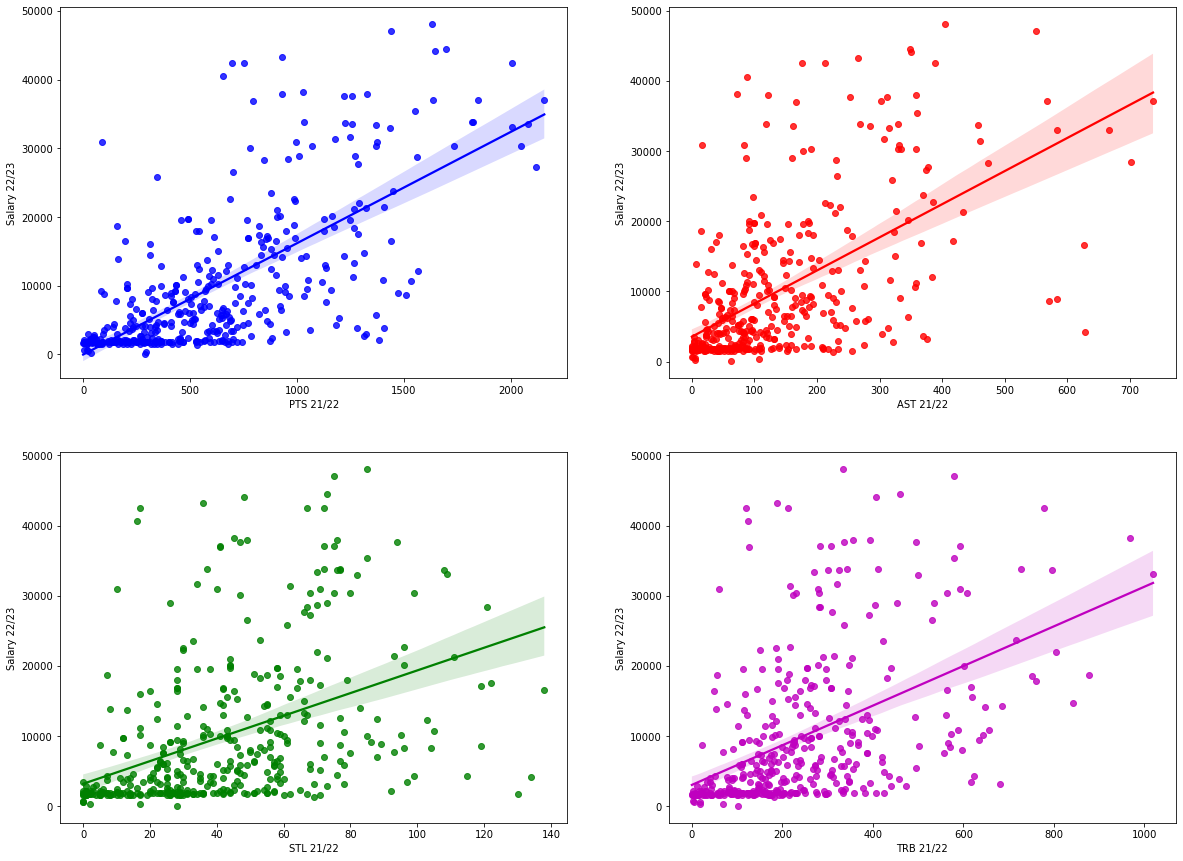

In [28]:
# Set up figure
f, axes = plt.subplots(2, 2, figsize=(20, 15))

# Regressionplot
sns.regplot(x = df1['PTS 21/22'], y = df1['Salary 22/23'], color="b", ax=axes[0, 0])
sns.regplot(x = df1['AST 21/22'], y = df1['Salary 22/23'], color="r", ax=axes[0, 1])
sns.regplot(x = df1['STL 21/22'], y = df1['Salary 22/23'], color="g", ax=axes[1, 0])
sns.regplot(x = df1['TRB 21/22'], y = df1['Salary 22/23'], color="m", ax=axes[1, 1])

선택된 모든 통계적 수치들과 연봉 사이에는 positive한 선형 관계가 있다.

<AxesSubplot:xlabel='eFG% 21/22', ylabel='Salary 22/23'>

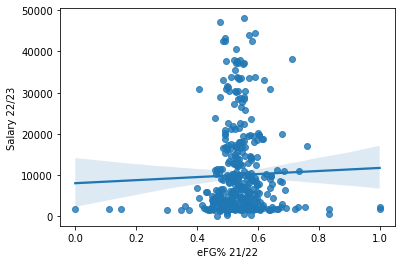

In [29]:
# Relationship with effecitve field goal percentage
sns.regplot(x = df1['eFG% 21/22'], y = df1['Salary 22/23'])

농구에서는 2점슛과 3점슛 간의 차이가 있기 때문에 normal field goal percentage 대신 effective field goal percentage를 선택했다.<br>
그러나 위 그래프에서 확인할 수 있듯이 postive한 선형 관계를 관찰하기 어렵다.<br>
(eFG%가 높으면서 연봉이 낮은 선수들은 있지만, eFG%가 낮으면서 높은 연봉을 받는 선수는 존재하지 않는다.)

<AxesSubplot:xlabel='MP 21/22', ylabel='Salary 22/23'>

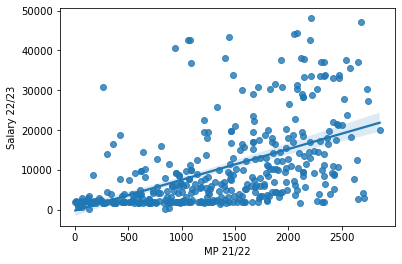

In [30]:
# Relationship with minutes played per game
sns.regplot(x = df1['MP 21/22'], y = df1['Salary 22/23'])

경기당 경기 시간과 연봉 사이에는 exponential relationship으로 보이는 positive relationship이 존재한다.<br> 
그러나 좋은 기록을 가지는 선수는 다음 시즌에 높은 연봉과 많은 경기시간을 보장 받을 가능성이 높기 때문에 해당 관계의 분석에 신중할 필요가 있다.<br> 
즉, 이러한 postive relationship은 기록에서 기반한 것으로 판단이 가능하다.

<AxesSubplot:xlabel='Age 21/22', ylabel='Salary 22/23'>

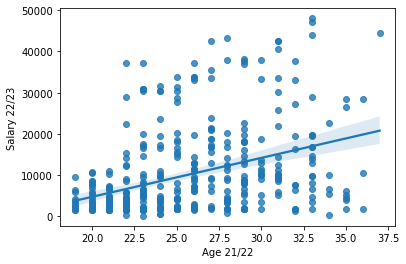

In [31]:
# Relationship with age
sns.regplot(x = df1['Age 21/22'], y = df1['Salary 22/23'])

선수의 나이와 연봉 사이에는 선형적인 관계가 없다.

<AxesSubplot:xlabel='Pos', ylabel='Salary 22/23'>

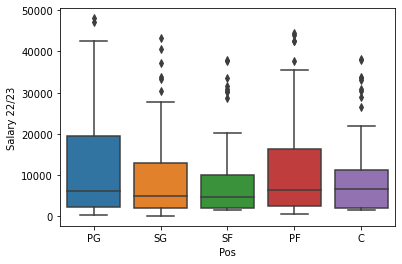

In [32]:
# Relationship with Position
sns.boxplot(x = 'Pos', y = 'Salary 22/23', data = df1, order = ['PG', 'SG', 'SF', 'PF', 'C'])

### Correlation matrix

지금까지의 분석은 직관에 따라 연봉을 결정하는 데 있어 중요하다고 생각되는 요소들에 기반을 두고 진행했다.<br>
좀 더 객관적인 분석을 진행하고 변수 간의 관계에 대하여 완벽한 개요를 얻기 위해서 히트맵을 활용한다.

C:\Users\borus\AppData\Local\Temp\ipykernel_17372\2400058927.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor_matrix, dtype = np.bool))


<AxesSubplot:>

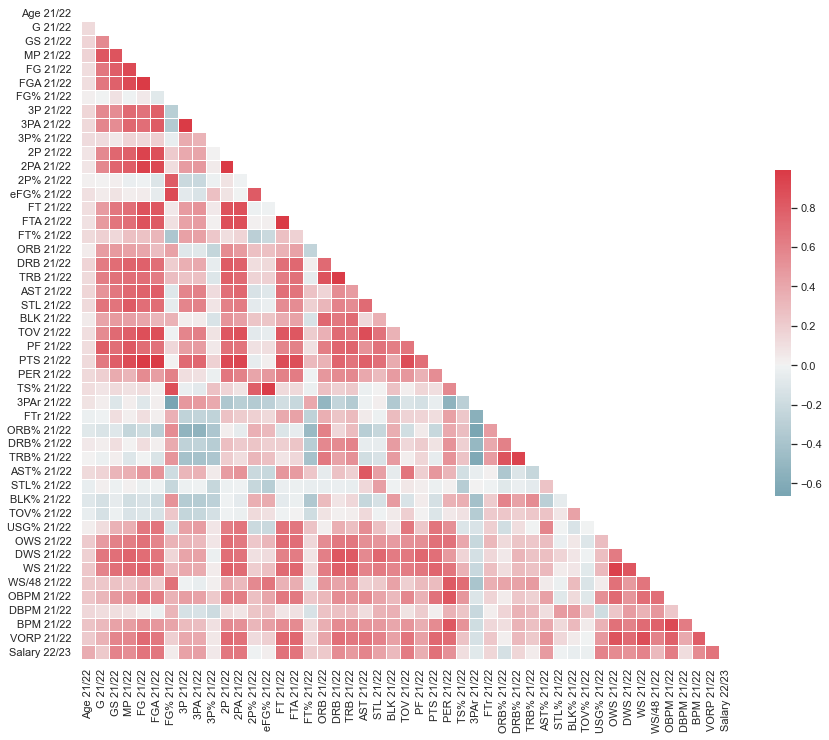

In [33]:
sns.set(style = "white")
cor_matrix = df1.loc[:, 'Age 21/22': 'Salary 22/23'].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor_matrix, dtype = np.bool))

plt.figure(figsize = (15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(cor_matrix, mask = mask, cmap = cmap, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

히트맵을 통한 분석

1. 다중 공선성: 정사각형의 색깔이 붉을수록 높은 상관 관계를 가지는 변수들로, 예측 모델에 거의 동일한 정보를 제공하고 추정에 대한 분산을 증가시킨다. 회귀 분석은 특징들 간의 독립성을 전제로 하기 때문에 올바른 회귀 분석을 위해서는 이러한 쌍을 제거해야한다. 다중 공선성은 분산팽창요인(VIF, Variance Inflation Factor) 이라는 계수로 평가할 수 있으며, 일반적으로 VIF 계수가 10~15 정도를 넘으면 다중 공선성 문제가 발생했다고 판단한다.


2. 22/23 시즌 연봉과의 상관관계: 앞서 분석했듯이, 연봉과 네 가지의 주요 통계 요소들 사이에는 선형적인 관계가 존재한다. 그러나 이 밖에도 추가적으로 고려해야 할 다른 변수들도 있음을 확인할 수 있다.

연봉과 경기당 플레이 시간(MP, minutes played)이나 선발 출전 횟수(GS, games started)의 상관관계를 분석할 때는 신중해야 하는데, 단순하게 선발 출전을 많이 하는 선수가 더 많은 돈을 번다고 할 수 없기 때문이다. 공격과 수비에 대한 통계를 참고하여 코치는 선수가 경기에 얼마나 오래 출전할 지를 결정하고, 이에 따라 다음 시즌의 연봉 역시 결정되므로 인과관계라고 하기는 어렵다. 다만 총 게임 수(G)는 모델에 활용이 가능하다. 이 통계는 선수의 취약성과 연봉의 관계를 측정할 수 있다. 또한 높은 상관관계로 인해 TOV(Turnover)가 많을수록 연봉이 높아진다고 말하기는 어렵다.  공격력과 수비력이 좋은 선수는 더 많은 경기 시간과 더 높은 연봉을 보장 받는다. 그렇기 때문에 연봉이 높은 좋은 선수는 경기 시간이 많아지고, 평균적으로 턴오버 역시 더 많을 수 밖에 없다.

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

V = df1[['Age 21/22', 'G 21/22', 'GS 21/22', 'MP 21/22', 'FG 21/22', 'FGA 21/22',
         'FG% 21/22', '3P 21/22', '3PA 21/22', '2P 21/22', '2PA 21/22', '2P% 21/22', 
         'eFG% 21/22', 'FT 21/22', 'FTA 21/22', 'ORB 21/22', 'DRB 21/22', 'TRB 21/22', 
         'AST 21/22', 'STL 21/22', 'BLK 21/22', 'TOV 21/22', 'PF 21/22', 'PTS 21/22', 
         'PER 21/22', 'TS% 21/22', '3PAr 21/22', 'FTr 21/22', 'ORB% 21/22', 'DRB% 21/22',
         'TRB% 21/22', 'AST% 21/22', 'STL% 21/22', 'BLK% 21/22', 'TOV% 21/22', 'USG% 21/22',
         'OWS 21/22', 'DWS 21/22', 'WS 21/22', 'WS/48 21/22' ,'OBPM 21/22', 'DBPM 21/22',
         'BPM 21/22', 'VORP 21/22']]

# 특징마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]
vif["features"] = V.columns
vif.round(1)

C:\Users\borus\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,46.6,Age 21/22
1,63.7,G 21/22
2,12.5,GS 21/22
3,340.2,MP 21/22
4,inf,FG 21/22
5,inf,FGA 21/22
6,7990.1,FG% 21/22
7,inf,3P 21/22
8,inf,3PA 21/22
9,inf,2P 21/22


다중 공선성 문제가 없는 적절한 특징들을 선정한다.

* 선정 과정
1. VIF 계수가 높은 특징을 우선적으로 제거한다. 단, (FG, FG%)와 같이 유사한 특징 중에서는 하나만을 제거한다.

2. 다시 다중 공선성을 검증한다.<br>
(VIF 계수가 비정상적으로 높은 특징을 제거해주면, 다른 특징들의 공선성이 감소하는 것을 확인할 수 있다.)

3. 여전히 VIF 계수가 높은 특징들을 제거한다.

In [35]:
V = df1[['Age 21/22', 'G 21/22', 'GS 21/22', 'MP 21/22', 'FGA 21/22','3P 21/22', '2PA 21/22', 
         'FT 21/22', 'DRB 21/22', 'AST 21/22', 'STL 21/22', 'BLK 21/22', 'TOV 21/22', 'PF 21/22', 'PTS 21/22', 
         'PER 21/22', 'TS% 21/22', '3PAr 21/22', 'FTr 21/22', 'AST% 21/22', 'STL% 21/22', 
         'BLK% 21/22', 'TOV% 21/22', 'USG% 21/22','WS/48 21/22' ,'OBPM 21/22', 'VORP 21/22']]

# 특징마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(V.values, i) for i in range(V.shape[1])]
vif["features"] = V.columns
vif.round(1)

,VIF Factor,features
0,43.4,Age 21/22
1,58.0,G 21/22
2,12.1,GS 21/22
3,224.7,MP 21/22
4,1385.5,FGA 21/22
5,230.9,3P 21/22
6,607.3,2PA 21/22
7,39.9,FT 21/22
8,32.0,DRB 21/22
9,58.1,AST 21/22


### What about the relationship between the absolute changes and salary?

20/21 시즌과 21/22 시즌의 성적 변화가 선수들의 연봉을 결정하는 데 영향을 미치는 지 확인한다.  

C:\Users\borus\AppData\Local\Temp\ipykernel_17372\3233410418.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor_matrix, dtype = np.bool))


<AxesSubplot:>

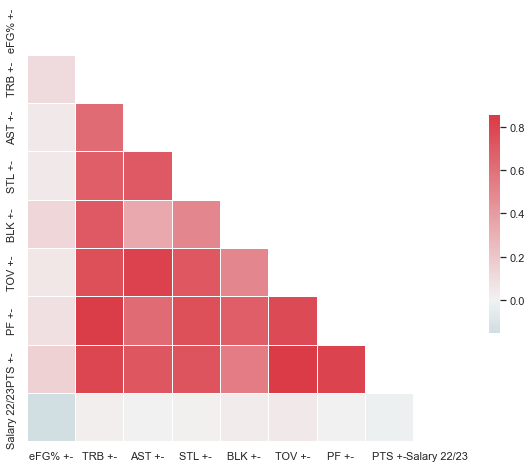

In [36]:
cor_matrix = df2.loc[:, ['eFG% +-','TRB +-', 'AST +-', 'STL +-', 'BLK +-', 'TOV +-', 'PF +-', 'PTS +-', 
                        'Salary 22/23']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cor_matrix, dtype = np.bool))

plt.figure(figsize = (10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(cor_matrix, mask = mask, cmap = cmap, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

Absolute change와 연봉 간에는 선형적인 관계는 없어 보인다.<br> 그러므로 예측 모델을 구현 하는 데 있어서 absolute changes와 20/21 시즌의 통계 수치를 제외한다.

## 3. Data Preparation

### Feature Scaling

특징들 간의 단위를 맞추기 위해서 StandardScaler를 이용한 Scaling을 진행한다.

In [37]:
# Define the function scaling for each feature
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [38]:
# Scaling for each features
scale_columns = ['Age 21/22', 'G 21/22', 'GS 21/22', 'MP 21/22', 'FG 21/22', 'FGA 21/22',
         'FG% 21/22', '3P 21/22', '3PA 21/22', '2P 21/22', '2PA 21/22', '2P% 21/22', 
         'eFG% 21/22', 'FT 21/22', 'FTA 21/22', 'ORB 21/22', 'DRB 21/22', 'TRB 21/22', 
         'AST 21/22', 'STL 21/22', 'BLK 21/22', 'TOV 21/22', 'PF 21/22', 'PTS 21/22', 
         'PER 21/22', 'TS% 21/22', '3PAr 21/22', 'FTr 21/22', 'ORB% 21/22', 'DRB% 21/22',
         'TRB% 21/22', 'AST% 21/22', 'STL% 21/22', 'BLK% 21/22', 'TOV% 21/22', 'USG% 21/22',
         'OWS 21/22', 'DWS 21/22', 'WS 21/22', 'WS/48 21/22' ,'OBPM 21/22', 'DBPM 21/22',
         'BPM 21/22', 'VORP 21/22']
df1 = standard_scaling(df1, scale_columns)
df1.head(5)

,level_0,index,Player,Pos,Age 21/22,Tm 21/22,G 21/22,GS 21/22,MP 21/22,FG 21/22,...,USG% 21/22,OWS 21/22,DWS 21/22,WS 21/22,WS/48 21/22,OBPM 21/22,DBPM 21/22,BPM 21/22,VORP 21/22,Salary 22/23
0,0,0,Precious Achiuwa,C,-0.858388,TOR,0.921005,-0.039430,0.547006,0.234915,...,-0.094090,-0.637248,0.747301,-0.165432,-0.446067,-0.597195,-0.424855,-0.666235,-0.750544,2840.160
1,1,2,Steven Adams,C,0.569737,MEM,1.073615,1.699017,0.921009,-0.102166,...,-1.279017,1.240203,1.665465,1.518277,1.032027,0.595834,0.728297,0.796885,0.963516,17926.829
2,2,3,Bam Adebayo,C,-0.382346,MIA,0.056218,0.996241,0.683503,1.099069,...,1.090837,1.129765,2.175555,1.674901,1.429365,0.874207,1.521090,1.369410,1.508899,30351.780
3,3,6,Nickeil Alexander-Walker,SG,-0.620367,TOT,0.514047,-0.298348,0.193476,0.161370,...,0.926771,-1.465535,-0.272880,-1.105176,-1.510930,-0.517660,-0.785215,-0.761656,-0.828456,5009.633
4,4,7,Grayson Allen,SG,0.093695,MIL,0.564916,1.181182,0.656204,0.173628,...,-0.695669,0.688012,0.033175,0.500220,0.189673,0.436763,-0.136567,0.287973,0.262310,8500.000


### Define target variable and features

In [39]:
y = df1.loc[:, 'Salary 22/23']

x = df1.loc[:, ['Pos', 'Age 21/22', 'G 21/22', 'GS 21/22', 'MP 21/22', 'FGA 21/22','3P 21/22', '2PA 21/22', 
         'FT 21/22', 'DRB 21/22', 'AST 21/22', 'STL 21/22', 'BLK 21/22', 'TOV 21/22', 'PF 21/22', 'PTS 21/22', 
         'PER 21/22', 'TS% 21/22', '3PAr 21/22', 'FTr 21/22', 'AST% 21/22', 'STL% 21/22', 
         'BLK% 21/22', 'TOV% 21/22', 'USG% 21/22','WS/48 21/22' ,'OBPM 21/22', 'VORP 21/22']] 

print(x.shape)
print(y.shape)

(409, 28)
(409,)


### One-Hot encoding for feature position

범주형 변수를 다루기 위해서 One-Hot encoder를 사용한다.

In [40]:
# Instantiate OneHotEncoder
ohe = OneHotEncoder(categories = [['PG', 'SG', 'SF', 'PF', 'C']])

# Apply one-hot encoder
x_ohe = pd.DataFrame(ohe.fit_transform(x['Pos'].to_frame()).toarray())

# Get feature names
x_ohe.columns = ohe.get_feature_names(['Pos'])

# One-hot encoding removed index; put it back
x_ohe.index = x.index

# Add one-hot encoded columns to numerical features and remove categorical column
x = pd.concat([x, x_ohe], axis=1).drop(['Pos'], axis=1)

# How does it look like?
x.head()

C:\Users\borus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Age 21/22,G 21/22,GS 21/22,MP 21/22,FGA 21/22,3P 21/22,2PA 21/22,FT 21/22,DRB 21/22,AST 21/22,...,TOV% 21/22,USG% 21/22,WS/48 21/22,OBPM 21/22,VORP 21/22,Pos_PG,Pos_SG,Pos_SF,Pos_PF,Pos_C
0,-0.858388,0.921005,-0.039430,0.547006,0.326680,-0.215207,0.645045,-0.177885,1.006198,-0.420419,...,-0.153819,-0.094090,-0.446067,-0.597195,-0.750544,0.0,0.0,0.0,0.0,1.0
1,0.569737,1.073615,1.699017,0.921009,-0.299895,-1.107834,0.375175,0.139407,1.620256,0.916290,...,1.686755,-1.279017,1.032027,0.595834,0.963516,0.0,0.0,0.0,0.0,1.0
2,-0.382346,0.056218,0.996241,0.683503,0.687176,-1.107834,1.808859,1.704711,1.737219,0.409262,...,0.533624,1.090837,1.429365,0.874207,1.508899,0.0,0.0,0.0,0.0,1.0
3,-0.620367,0.514047,-0.298348,0.193476,0.546983,0.565843,0.202289,-0.146156,-0.287707,0.148066,...,-0.153819,0.926771,-1.510930,-0.517660,-0.828456,0.0,1.0,0.0,0.0,0.0
4,0.093695,0.564916,1.181182,0.656204,0.229404,1.426591,-0.480819,-0.325954,0.004701,-0.282139,...,-1.173897,-0.695669,0.189673,0.436763,0.262310,0.0,1.0,0.0,0.0,0.0


### Split Data into train and test

회귀 분석을 위한 학습, 테스트 데이터셋 분리한다.

In [41]:
# Split data using train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(327, 32)
(327,)
(82, 32)
(82,)


### Normalise y

앞서 종속 변수(dependent variable)가 정규 분포를 근사적으로 따르지 않는 것을 확인했다.<br>
그러므로 머신러닝 모델을 구현하기 위해서 정규화를 해준다.

C:\Users\borus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\borus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y_test', ylabel='Density'>

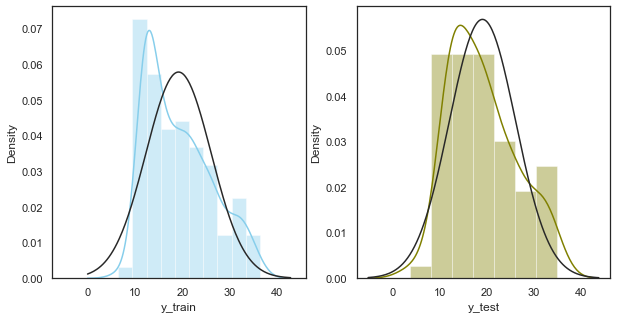

In [42]:
#Apply cube-root transformation
y_train = pd.DataFrame(np.cbrt([y_train])).T
y_test = pd.DataFrame(np.cbrt([y_test])).T
y = pd.DataFrame(np.cbrt([y])).T

#transformed histogram and normal probability plot
f, axes = plt.subplots(1, 2, figsize = (10, 5), sharex = True)
sns.distplot(y_train, color = "skyblue", fit = norm, ax = axes[0], axlabel = "y_train")
sns.distplot(y_test, color = "olive",fit = norm, ax = axes[1], axlabel = "y_test")
#sns.distplot(y, color = "olive",fit = norm, axlabel = "y")

## 4. Building Machine Learning Models

### Basic machine learning algorithms

Model 평가 기준으로 RMS(Root-Mean-Squared Error)와 R-Squared를 활용한다.

1. RMSE score: 실제값과 예측값의 차이를 절대값으로 나타낸 것으로, 해당 값이 높을수록 예측이 부정확하다는 뜻이다.


2. R-Squared score: 회귀 분석으로 추정한 모델이 주어진 데이터를 얼마나 잘 설명하는지 나타내는 점수로, 데이터를 잘 설명하는 모델일수록 1에 가깝다.

In [43]:
# Function which uses an algorithm as input and returns the desired accuracy metrics and some predictions

def alg_fit(alg, x_train, y_train, x_test, name, y_true, df, mse, r2):
    
    # Model selection
    mod = alg.fit(x_train, y_train)
    
    # Prediction
    y_pred = mod.predict(x_test)
    
    # Accuracy
    acc1 = round(mse(y_test, y_pred), 4)
    acc2 = round(r2(y_test, y_pred), 4)
    
    # Accuracy table
    x_test['y_pred'] = mod.predict(x_test)
    df_acc = pd.merge(df, x_test, how = 'right')
    x_test.drop(['y_pred'], axis = 1, inplace = True)
    df_acc = df_acc[[name, y_true, 'y_pred']]
    df_acc.sort_values(by = y_true, ascending = False, inplace = True)
    df_acc['y_pred'] = df_acc['y_pred']**3
    
    return y_pred, acc1, acc2, df_acc

### Linear Regression

In [44]:
# Linear Regression
y_pred_lin, mse_lin, r2_lin, df_acc_lin = alg_fit(LinearRegression(), x_train, y_train, x_test, 'Player', 'Salary 22/23', 
                                                  df1, metrics.mean_squared_error, metrics.r2_score)

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_lin), 4))
print("R-squared: %s" % r2_lin)
df_acc_lin.head(10)

Root Mean Squared Error: 3.8856
R-squared: 0.6933


,Player,Salary 22/23,y_pred
76,Giannis Antetokounmpo,42492.492,59731.383830
69,Klay Thompson,40600.080,22576.393981
16,Kyrie Irving,36934.550,19990.313771
23,Andrew Wiggins,33616.770,16127.067928
52,Nikola Jokić,33047.803,58484.822043
66,James Harden,33000.000,39816.310938
49,Brandon Ingram,31650.600,19881.151873
1,Jayson Tatum,30351.780,42368.570583
20,Gordon Hayward,30075.000,13761.682952
62,Jalen Brunson,27733.332,11394.933372


### Ridge Regression

선형 회귀(Linear Regression) 모델은 다중 공선성 문제를 가지기 때문에 이에 대한 적합한 해결책을 찾아야 한다.<br>
다중 공선성 문제는 부정확한 추정을 유발하고 큰 표준 오차를 가지게 한다.<br> 
Ridge regression은 람다 값을 조절해 추정에 개선된 효율성을 제공하여 해당 문제를 완화한다.

In [45]:
# Ridge Regression
y_pred_rid, mse_rid, r2_rid, df_acc_rid = alg_fit(Ridge(alpha = 1), x_train, y_train, x_test, 'Player', 'Salary 22/23',
                                                  df1, metrics.mean_squared_error, metrics.r2_score)

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_rid), 4))
print("R-squared: %s" % r2_rid)
df_acc_rid.head(10)

Root Mean Squared Error: 3.79
R-squared: 0.7082


,Player,Salary 22/23,y_pred
76,Giannis Antetokounmpo,42492.492,54627.392934
69,Klay Thompson,40600.080,21316.157720
16,Kyrie Irving,36934.550,20255.658641
23,Andrew Wiggins,33616.770,17166.992925
52,Nikola Jokić,33047.803,52640.956232
66,James Harden,33000.000,37577.001448
49,Brandon Ingram,31650.600,20472.171229
1,Jayson Tatum,30351.780,39550.904853
20,Gordon Hayward,30075.000,14598.786890
62,Jalen Brunson,27733.332,11678.919075


### Lasso Regression

Lasso Regression는 Ridge Regression과 개념적으로 매우 유사하다. 0이 아닌 계수에 대해 패널티를 추가로 부여하며, Ridge Regression과 다르게 계수의 제곱합이 아닌 계수의 절대값으로 제한한다.

In [46]:
# Lasso Regression
y_pred_las, mse_las, r2_las, df_acc_las = alg_fit(Lasso(alpha = 0.001), x_train, y_train, x_test, 'Player', 'Salary 22/23',
                                                  df1, metrics.mean_squared_error, metrics.r2_score)

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_las), 4))
print("R-squared: %s" % r2_las)
df_acc_las.head(10)

Root Mean Squared Error: 3.8648
R-squared: 0.6966


C:\Users\borus\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+03, tolerance: 1.556e+00
  model = cd_fast.enet_coordinate_descent(


,Player,Salary 22/23,y_pred
76,Giannis Antetokounmpo,42492.492,58924.786829
69,Klay Thompson,40600.080,22622.242458
16,Kyrie Irving,36934.550,20332.399395
23,Andrew Wiggins,33616.770,16432.980208
52,Nikola Jokić,33047.803,57119.586172
66,James Harden,33000.000,39553.579669
49,Brandon Ingram,31650.600,19827.380669
1,Jayson Tatum,30351.780,41247.310983
20,Gordon Hayward,30075.000,14053.676132
62,Jalen Brunson,27733.332,11499.315611


### Cross Validation

Cross Validation을 통해 보다 정교한 정확도 측정을 제공한다.

In [47]:
def alg_fit_cv(alg, x, y, mse, r2):
    
    # Cross validation
    cv = KFold(shuffle = True, random_state = 0, n_splits = 5)
    
    # Accuracy
    scores1 = cross_val_score(alg, x, y, cv = cv, scoring = mse)
    scores2 = cross_val_score(alg, x, y, cv = cv, scoring = r2)
    acc1_cv = round(scores1.mean(), 4)
    acc2_cv = round(scores2.mean(), 4)
    
    return acc1_cv, acc2_cv

In [48]:
# Linear Regression

mse_cv_lin, r2_cv_lin = alg_fit_cv(LinearRegression(), x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_lin*-1), 4))
print("R-squared: %s" % r2_cv_lin)

Root Mean Squared Error: 4.0602
R-squared: 0.6549


In [49]:
# Ridge Regression
mse_cv_rid, r2_cv_rid = alg_fit_cv(Ridge(alpha = 23), x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_rid*-1), 4))
print("R-squared: %s" % r2_cv_rid)

Root Mean Squared Error: 3.9691
R-squared: 0.6681


In [50]:
# Lasso Regression
mse_cv_las, r2_cv_las = alg_fit_cv(Lasso(), x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_las*-1), 4))
print("R-squared: %s" % r2_cv_las)

Root Mean Squared Error: 4.349
R-squared: 0.6035


### Advanced models


### LightGBM Regressor

In [51]:
# LightGBM Regressor (after some parameter tuning)
lgbm = LGBMRegressor(objective = 'regression',
                     num_leaves = 20,
                     learning_rate = 0.03,
                     n_estimators = 200,
                     max_bin = 50,
                     bagging_fraction = 0.85,
                     bagging_freq = 4,
                     bagging_seed = 6,
                     feature_fraction = 0.2,
                     feature_fraction_seed = 7,
                     verbose = -1)

mse_cv_lgbm, r2_cv_lgbm = alg_fit_cv(lgbm, x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_lgbm*-1), 4))
print("R-squared: %s" % r2_cv_lgbm)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.85, subsample=1.0 will be ignored. Current value: bagging_fraction=0.85
[LightGBM] [Warning] bagging_freq is set=4, subsample_f

### XGB-Regressor

In [52]:
# XGB-Regressor (after some parameter tuning)
xgb = XGBRegressor(n_estimators = 300,
                   max_depth = 2,
                   min_child_weight = 0,
                   gamma = 8,
                   subsample = 0.6,
                   colsample_bytree = 0.9,
                   objective = 'reg:squarederror',
                   nthread = -1,
                   scale_pos_weight = 1,
                   seed = 27,
                   learning_rate = 0.02,
                   reg_alpha = 0.006)

mse_cv_xgb, r2_cv_xgb = alg_fit_cv(xgb, x, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_xgb*-1), 4))
print("R-squared: %s" % r2_cv_xgb)

Root Mean Squared Error: 3.8072
R-squared: 0.6957


### Feature importance

XGB-Regressor를 사용하여 가장 높은 정확도 점수를 얻었기 때문에 이를 이용한 모델로 Feature importance를 측정한다.

In [53]:
# Model
mod = xgb.fit(x, y)

# Feature importance
df_feature_importance = pd.DataFrame(xgb.feature_importances_, index = x.columns, 
                                     columns = ['feature importance']).sort_values('feature importance', ascending = False)
df_feature_importance

,feature importance
PTS 21/22,0.216269
FGA 21/22,0.152253
VORP 21/22,0.078079
GS 21/22,0.076530
OBPM 21/22,0.059482
USG% 21/22,0.046082
Age 21/22,0.032772
FT 21/22,0.030347
PER 21/22,0.029042
DRB 21/22,0.026476


### New features

높은 중요도를 가진 특징을 사용한다. 다만 일부 특징의 경우, 중복되거나 다른 특징에 가깝기 때문에 사용할 수 없다. 예를 들어, 경기당 필드골(FG)은 이미 경기당 포인트(PTS)에 포함되기 때문에 필요하지 않다.

In [54]:
# Drop out features with low importance or which are redundant
x_new = x.loc[:, ['Age 21/22', 'GS 21/22', 'FGA 21/22','3P 21/22', '2PA 21/22', 'FT 21/22',
    'DRB 21/22', 'AST 21/22', 'PTS 21/22', 'PER 21/22', 'USG% 21/22','OBPM 21/22', 'VORP 21/22']]

### Final Model


In [55]:
# XGB-Regressor (after some parameter tuning)
xgb_new = XGBRegressor(n_estimators = 270,
                       max_depth = 2,
                       min_child_weight = 0,
                       gamma = 18,
                       subsample = 0.7,
                       colsample_bytree = 0.9,
                       objective = 'reg:squarederror',
                       nthread = -1,
                       scale_pos_weight = 1,
                       seed = 27,
                       learning_rate = 0.023,
                       reg_alpha = 0.02)

mse_cv_xgb, r2_cv_xgb = alg_fit_cv(xgb_new, x_new, y, 'neg_mean_squared_error', 'r2')

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_cv_xgb*-1), 4))
print("R-squared: %s" % r2_cv_xgb)

Root Mean Squared Error: 3.7863
R-squared: 0.6993


### Let's see how it performs on some test data

In [56]:
# Split data now with x_new
x_train, x_test, y_train, y_test = train_test_split(x_new, y, test_size = 0.2, random_state = 0)

# Use function to fit algorithm
y_pred_xgb, mse_xgb, r2_xgb, df_acc_xgb = alg_fit(xgb_new, x_train, y_train, x_test, 'Player', 'Salary 22/23', 
                                                  df1, metrics.mean_squared_error, metrics.r2_score)

print("Root Mean Squared Error: %s" % round(np.sqrt(mse_xgb), 4))
print("R-squared: %s" % r2_xgb)
df_acc_xgb.head(10)

Root Mean Squared Error: 3.4604
R-squared: 0.7568


,Player,Salary 22/23,y_pred
76,Giannis Antetokounmpo,42492.492,36416.914062
69,Klay Thompson,40600.080,24270.738281
16,Kyrie Irving,36934.550,32994.105469
23,Andrew Wiggins,33616.770,15185.351562
52,Nikola Jokić,33047.803,33036.679688
66,James Harden,33000.000,38974.101562
49,Brandon Ingram,31650.600,34730.261719
1,Jayson Tatum,30351.780,26630.937500
20,Gordon Hayward,30075.000,15767.200195
62,Jalen Brunson,27733.332,15219.522461


### Visualization

예상 연봉과 실제 연봉 비교한다.

<AxesSubplot:xlabel='Player'>

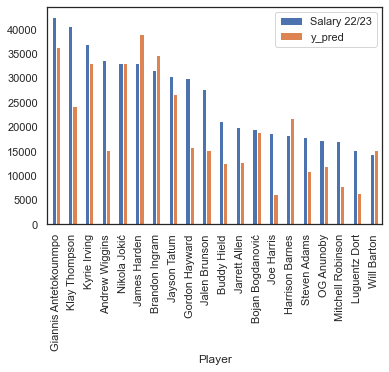

In [57]:
df_acc_xgb.head(20).plot(x='Player', y=['Salary 22/23', 'y_pred'], kind="bar")